In [29]:
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from trdg.generators import GeneratorFromStrings
import time

In [3]:
df1 = pd.read_csv('../data/public_training_data.csv')
df2 = pd.read_csv('../data/public_valid_data.csv')

In [4]:
fake_label = df1['label'].tolist() + df2['label'].tolist() 
fake_label = [x.strip() for x in fake_label if x.strip()]

In [5]:
def random_space(txt):
    txt_list = list(txt)
    n_space = np.random.choice(range(3),1)[0]
    space_idx = sorted(np.random.choice(range(1,len(txt)+1), min(n_space,len(txt)),replace=False))
    pun_choice = np.random.choice([' ','-'],n_space)
    for _idx,_pun in zip(space_idx,pun_choice):
        txt_list.insert(_idx,_pun)
    return ''.join(txt_list)

In [6]:
fake_label = [random_space(x) for x in fake_label]

In [7]:
fake_original_label = [x.replace(' ','').replace('-','') for x in fake_label]

# generate target label

In [30]:
font_use = glob('./font/*')

### Double vision without background 


In [31]:
# 背景必須為黑色
def generate_double(_img_array):
    img_array = _img_array.copy()
    img_array_180 = cv2.rotate(img_array,cv2.ROTATE_180)
    
    # 遮罩圖片
    black_array = np.ones(img_array_180.shape,dtype=int)*1
    random_alpha1 = np.random.normal(0.6,0.1,size=1)[0] # 180
    random_alpha2 = np.random.normal(0.8,0.1,size=1)[0] # 0
    img_array = (img_array*random_alpha2 +black_array*(1-random_alpha2)).astype('int')
    img_array_180 = (img_array_180*random_alpha1 +black_array*(1-random_alpha1)).astype('int')
    
    # 位移圖片
    randon_shift_x = np.random.choice([1.1,1.2],1)[0]
    randon_shift_y = np.random.choice([1,1.2,1.3],1)[0]
    #print(random_alpha1,random_alpha2,randon_shift_x,randon_shift_y)
    padding_size =  (int(img_array.shape[0]*randon_shift_x),int(img_array.shape[1]*randon_shift_y),3)
    null_mat = np.ones(padding_size,dtype=int)* img_array[0,0,0]
    
    # 合成圖片
    random_kernel = np.random.choice([1,1,1,1,3,6,7,10],4)
    random_position = np.random.choice([0,1],1)[0]
    if random_position:
        null_mat[:img_array.shape[0],:img_array.shape[1],:] = img_array
        null_mat[-img_array_180.shape[0]:,-img_array_180.shape[1]:,:] += cv2.blur(img_array_180,tuple(random_kernel[:2]))
    else:
        null_mat[-img_array.shape[0]:,-img_array.shape[1]:,:] = img_array
        null_mat[:img_array_180.shape[0],:img_array_180.shape[1],:] += cv2.blur(img_array_180,tuple(random_kernel[-2:]))
        
    return null_mat

In [32]:
def rec_fake(n_sample=1,
             font_size=50,
             blur=1,
             fonts=font_use,
             character_spacing=10,
             double_ratio=0.1,
             reverse_ratio=0.1,
             bright=0.1,
             alpha=0.7
            ):
    '''
    n_sample: >6 (font type)
    font_size : 30-50
    blur: 1-6
    character_spacing: 10-30
    double_ratio : 0.1-0.3
    reverse_ratio: 0.1-0.3
    alpha : 0.6-1.0
    '''
    generator1 = GeneratorFromStrings(fake_label,count=n_sample,fonts=fonts,size=font_size,blur=blur,
                                      random_skew=True,random_blur=True,skewing_angle=1,fit=False,
                                      background_type=3, text_color='#e0d7d7,#e0d8d9',
                                      image_dir='./pure_black',character_spacing=character_spacing,      
                                      stroke_width=0,stroke_fill='#000000',image_mode='RGB',margins=(10,10,10,10))
    
    double_stat = np.random.binomial(1,p=double_ratio,size=n_sample)
    reverse_stat = np.random.binomial(1,p=reverse_ratio,size=n_sample)
    back_array = [cv2.imread(f) for f in glob('./background/*.png')]
    background = np.random.choice(back_array,n_sample)
    
    fake_original = {}
    for idx,(d_stat,r_stat,back_img,(img,label)) in tqdm(enumerate(zip(double_stat,reverse_stat,background,generator1)),
                                                         total=n_sample):
        img_array = np.array(img)
        if d_stat:
            img_array = generate_double(img_array)
        elif r_stat:
            img_array = cv2.rotate(img_array,cv2.ROTATE_180)
        back_img = cv2.resize(back_img,img_array.shape[-2::-1],interpolation=cv2.INTER_NEAREST)
        tmp_fake = ( img_array*alpha+ back_img*(1-alpha) ).astype('int') 
        fake_original[f"{label}_{idx}"] = tmp_fake
    return fake_original

def rec_fake_csc(n_sample=1,
                 fonts=['./font/Writes_csc1019.ttf'],
                 font_size=50,
                 blur=1,
                 reverse_ratio=0.1,
                 double=False,
                 alpha=0.7
                ):
    
    generator_csc = GeneratorFromStrings(fake_original_label,count=n_sample,fonts=fonts,    
                                         size=font_size,blur=blur,random_skew=True,random_blur=True,skewing_angle=0,
                                         fit=False,background_type=3,text_color='#e0d7d7,#e0d8d9',
                                         image_dir='./pure_white/', character_spacing=0,stroke_width=0,
                                         stroke_fill='#000000',image_mode='RGB',margins=(0,0,0,0))
    
    reverse_stat = np.random.binomial(1,p=reverse_ratio,size=n_sample)
    back_array = [cv2.imread(f) for f in glob('./background/*.png')]
    background = np.random.choice(back_array,n_sample)

    fake_original = {}
    for idx,(r_stat,back_img,(img,label)) in tqdm(enumerate(zip(reverse_stat,background,generator_csc)),total=n_sample):
        img_array = np.array(img)
        img_array[img_array<250] = 60
        if r_stat:
            img_array = cv2.rotate(img_array,cv2.ROTATE_180)
        if double:
            img_array = generate_double(img_array)
        back_img = cv2.resize(back_img,img_array.shape[-2::-1],interpolation=cv2.INTER_NEAREST)
        #back_img = np.zeros(img_array.shape,dtype=int)
        tmp_fake = ( img_array*alpha+ back_img*(1-alpha) ).astype('int') 
        
        for i in range(1,3):
            tmp_fake[:,:,i] = tmp_fake[:,:,0]
        
        fake_original[f"{label}_{idx}"] = tmp_fake
    return fake_original


## Sample demo

100% 3/3 [00:00<00:00, 107.55it/s]


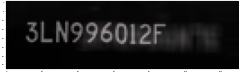

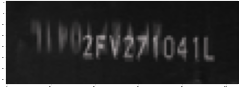

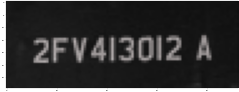

In [39]:
f_demo = rec_fake(3,font_size=35,blur=1,character_spacing=1,double_ratio=0.3,reverse_ratio=0.1,alpha=0.6)
for _label,_img in f_demo.items():
    plt.figure(figsize=(20,10),dpi=15)
    plt.imshow(_img)
    plt.show()

## Generate rec fake data

In [ ]:
f_data1 = rec_fake(6000,font_size=35,blur=1,character_spacing=1,double_ratio=0.3,reverse_ratio=0.1,alpha=0.6)
f_data2 = rec_fake(6000,font_size=45,blur=1,character_spacing=3,double_ratio=0.3,reverse_ratio=0.1,alpha=0.5)
f_data3 = rec_fake(6000,font_size=55,blur=1,character_spacing=3,double_ratio=0.3,reverse_ratio=0.1,alpha=0.6)
f_data4 = rec_fake(6000,font_size=65,blur=1,character_spacing=5,double_ratio=0.3,reverse_ratio=0.1,alpha=0.7)

In [ ]:
csc_data1 = rec_fake_csc(n_sample=6000,font_size=40,blur=1,reverse_ratio=0.2,double=False,alpha=0.9)
csc_data2 = rec_fake_csc(n_sample=6000,font_size=45,blur=1,reverse_ratio=0.2,double=False,alpha=0.9)
csc_data3 = rec_fake_csc(n_sample=6000,font_size=55,blur=1,reverse_ratio=0.3,double=True ,alpha=0.6)
csc_data4 = rec_fake_csc(n_sample=6000,font_size=65,blur=1,reverse_ratio=0.3,double=False,alpha=0.6)

In [95]:
hand_data1 = rec_fake(n_sample=6000,fonts=['./font/chfont2.ttf','./font/chfont1.ttf'],font_size=45,blur=1,reverse_ratio=0,double_ratio=0,alpha=0.1)
hand_data2 = rec_fake(n_sample=6000,fonts=['./font/chfont2.ttf','./font/chfont1.ttf'],font_size=55,blur=2,reverse_ratio=0,double_ratio=0,alpha=0.12)
hand_data3 = rec_fake(n_sample=6000,fonts=['./font/chfont2.ttf','./font/chfont1.ttf'],font_size=60,blur=1,reverse_ratio=0,double_ratio=0,alpha=0.1)
hand_data4 = rec_fake(n_sample=6000,fonts=['./font/chfont2.ttf','./font/chfont1.ttf'],font_size=70,blur=1,reverse_ratio=0,double_ratio=0,alpha=0.06)

100% 6000/6000 [00:53<00:00, 112.92it/s]
100% 6000/6000 [01:01<00:00, 96.83it/s] 
100% 6000/6000 [01:07<00:00, 88.53it/s]
100% 6000/6000 [01:19<00:00, 75.10it/s]


In [96]:
label_records = {}

idx = 0
for _fake in [hand_data1,hand_data2,hand_data3,hand_data4]:
    for _label,_img in tqdm(_fake.items(),total=len(_fake)):
        for i in range(2):
            if i:
                _img = cv2.rotate(_img,cv2.ROTATE_180)
            idx+=1
            fix_label = _label.split('_')[0].replace(' ','').replace('-','')
            file_name = f'./rec_fake_dataset/fake2_{idx}_crop{i}.jpg'
            label_records[file_name] = fix_label
            cv2.imwrite(file_name,_img)

100% 6000/6000 [00:04<00:00, 1489.39it/s]
100% 6000/6000 [00:05<00:00, 1125.24it/s]
100% 6000/6000 [00:06<00:00, 977.43it/s] 
100% 6000/6000 [00:07<00:00, 807.49it/s]


In [98]:
with open('rec_fake_label.txt','w') as f:
    for _path,_lab in label_records.items():
        f.write(f"{_path}\t{_lab}\n")